In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import joblib

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("lending_club_loan_two.csv", low_memory=False)
pd.set_option('display.max_columns', None)
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


### EDA

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,396030.0,14113.888089,8357.441341,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,396030.0,13.639400,4.472157,5.32,10.49,13.33,16.49,30.99
installment,396030.0,431.849698,250.727790,16.08,250.33,375.43,567.30,1533.81
annual_inc,396030.0,74203.175798,61637.621158,0.00,45000.00,64000.00,90000.00,8706582.00
dti,396030.0,17.379514,18.019092,0.00,11.28,16.91,22.98,9999.00
open_acc,396030.0,11.311153,5.137649,0.00,8.00,10.00,14.00,90.00
pub_rec,396030.0,0.178191,0.530671,0.00,0.00,0.00,0.00,86.00
revol_bal,396030.0,15844.539853,20591.836109,0.00,6025.00,11181.00,19620.00,1743266.00
revol_util,395754.0,53.791749,24.452193,0.00,35.80,54.80,72.90,892.30
total_acc,396030.0,25.414744,11.886991,2.00,17.00,24.00,32.00,151.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [6]:
df['emp_title'].value_counts().head(20)

emp_title
Teacher                     4389
Manager                     4250
Registered Nurse            1856
RN                          1846
Supervisor                  1830
Sales                       1638
Project Manager             1505
Owner                       1410
Driver                      1339
Office Manager              1218
manager                     1145
Director                    1089
General Manager             1074
Engineer                     995
teacher                      962
driver                       882
Vice President               857
Operations Manager           763
Administrative Assistant     756
Accountant                   748
Name: count, dtype: int64

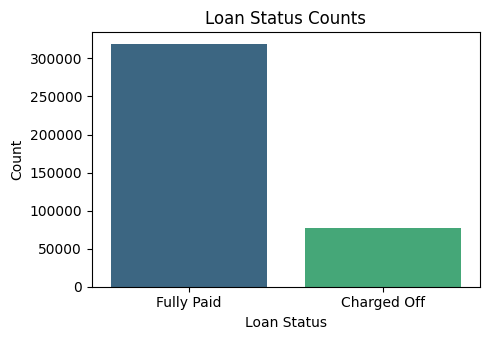

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


In [7]:
plt.figure(figsize=(5, 3.5))
sns.countplot(
    data=df,
    x='loan_status',
    order=df['loan_status'].value_counts().index,
    palette='viridis'
)

plt.title("Loan Status Counts")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
df.groupby(['loan_status'])['loan_amnt'].describe()

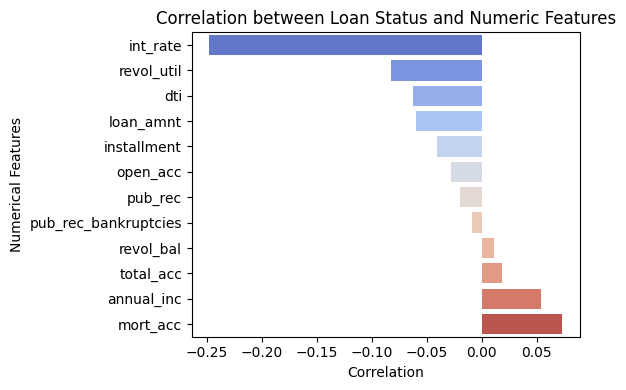

In [8]:
df['loan_status'] = df.loan_status.map({'Fully Paid': 1, 'Charged Off': 0})

corr_data = df.corr(numeric_only=True)['loan_status'].drop('loan_status').sort_values()

corr_df = corr_data.reset_index()
corr_df.columns = ['Numerical Features', 'Correlation']

plt.figure(figsize=(6, 4))
sns.barplot(
    data=corr_df,
    y='Numerical Features',
    x='Correlation',
    palette='coolwarm'
)

plt.title("Correlation between Loan Status and Numeric Features")
plt.xlabel("Correlation")
plt.ylabel("Numerical Features")
plt.tight_layout()
plt.show()

### EDA: Dealing with Missing Value Columns

In [9]:
df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1756
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

##### emp_title

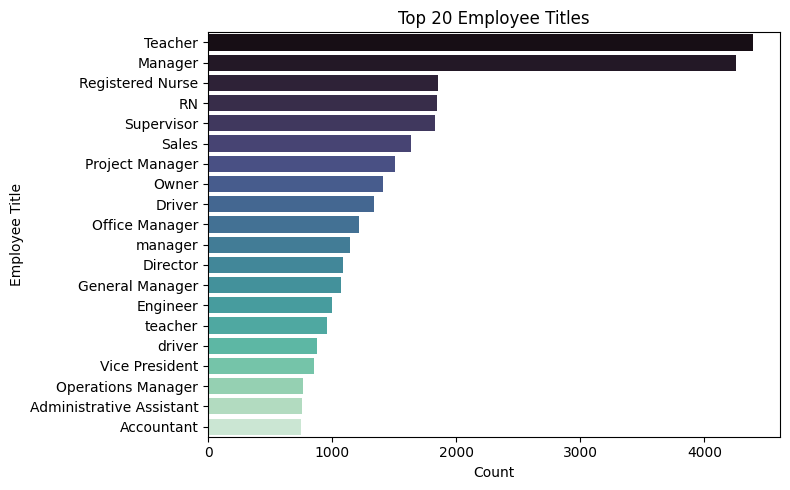

In [10]:
top_emp = df['emp_title'].value_counts().nlargest(20).reset_index()
top_emp.columns = ['emp_title', 'count']

plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_emp,
    y='emp_title',  # y for horizontal bars
    x='count',
    palette='mako'
)

plt.title("Top 20 Employee Titles")
plt.xlabel("Count")
plt.ylabel("Employee Title")
plt.tight_layout()
plt.show()


In [11]:
print("The percentage of unique Employee titles are : ",(df['emp_title'].nunique()/df.shape[0])*100)

The percentage of unique Employee titles are :  43.710072469257376


43% of Employee titles are unique. Hence this feature will not be very informative, hence we drop it

In [12]:
df = df.drop('emp_title', axis=1)

##### emp_length

In [13]:
df['emp_length'].value_counts(dropna=False)

emp_length
10+ years    126041
2 years       35827
< 1 year      31725
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
NaN           18301
9 years       15314
Name: count, dtype: int64

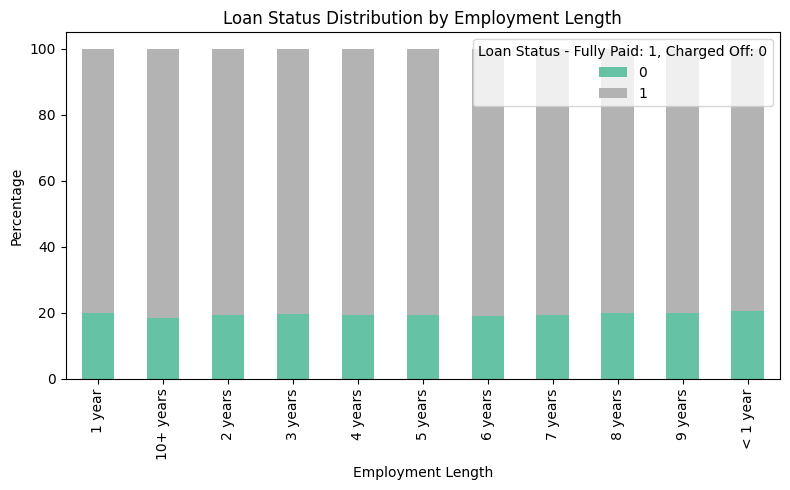

In [14]:
counts = df.groupby(['emp_length', 'loan_status']).size().unstack(fill_value=0)
proportions = counts.div(counts.sum(axis=1), axis=0) * 100  
proportions.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 5),
    colormap='Set2'
)

plt.title("Loan Status Distribution by Employment Length")
plt.ylabel("Percentage")
plt.xlabel("Employment Length")
plt.legend(title="Loan Status - Fully Paid: 1, Charged Off: 0")
plt.tight_layout()
plt.show()


Charge off rates are extremely similar across all employment lengths. So we are going to drop the emp_length column.

In [15]:
df = df.drop('emp_length', axis=1)

##### title, purpose

In [16]:
print(pd.DataFrame({'title': df['title'].head(10),'purpose': df['purpose'].head(10)}))

                     title             purpose
0                 Vacation            vacation
1       Debt consolidation  debt_consolidation
2  Credit card refinancing         credit_card
3  Credit card refinancing         credit_card
4    Credit Card Refinance         credit_card
5       Debt consolidation  debt_consolidation
6         Home improvement    home_improvement
7     No More Credit Cards         credit_card
8       Debt consolidation  debt_consolidation
9       Debt Consolidation  debt_consolidation


##### title is just a text description of purpose. So we will drop title

In [17]:
df = df.drop('title', axis=1)

##### revol_util, pub_rec_bankruptcies - Dropping Null rows as only 0.2% is Null

In [18]:
print(df['revol_util'].isna().sum())
print(df['pub_rec_bankruptcies'].isna().sum())

276
535


In [19]:
df = df.dropna(subset=['revol_util', 'pub_rec_bankruptcies'])

##### mort_acc - Imputing mort_acc with median after train/test split

### EDA: Categorical Columns

In [20]:
print([column for column in df.columns if df[column].dtype == object])

['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'earliest_cr_line', 'initial_list_status', 'application_type', 'address']


##### issue_d - extract year

In [21]:
df["issue_d"] = pd.to_datetime(df['issue_d'])
df['issue_d'] = df['issue_d'].dt.year
df['issue_d'].value_counts(dropna=False)

issue_d
2014    102795
2013     97597
2015     94216
2012     41169
2016     28067
2011     17427
2010      9241
2009      3813
2008       889
2007         5
Name: count, dtype: int64

##### earliest_cr_line - extract year

In [22]:
df["earliest_cr_line"] = pd.to_datetime(df['earliest_cr_line'])
df['earliest_cr_line'] = df['earliest_cr_line'].dt.year
df['earliest_cr_line'].value_counts()

earliest_cr_line
2000    29302
2001    29031
1999    26444
2002    25849
2003    23623
        ...  
1950        3
1951        3
1953        2
1944        1
1948        1
Name: count, Length: 65, dtype: int64

##### term - change to numerical

In [23]:
df.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [24]:
term_values = {' 36 months': 36, ' 60 months': 60}
df['term'] = df.term.map(term_values)

##### address - extract zip code

In [25]:
df['zip_code'] = df.address.apply(lambda x: x[-5:])
df.zip_code.value_counts()

zip_code
70466    56880
22690    56413
30723    56402
48052    55811
00813    45725
29597    45393
05113    45300
11650    11210
93700    11126
86630    10959
Name: count, dtype: int64

In [26]:
df = df.drop('address', axis=1)

##### drop grade as it is a subset of sub_grade

In [27]:
df = df.drop('grade', axis=1)

##### One-hot encoding for all remaining categorical variables

In [28]:
dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status', 'application_type', 'home_ownership', 'zip_code']
df = pd.get_dummies(df, columns=dummies, drop_first=True)

### Model Building 

##### Test Train Split

In [29]:
X = df.drop(['loan_status'], axis=1)

y = df['loan_status']

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.67,test_size=0.33,random_state=30)

##### Imputing mort_acc

In [30]:
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

##### Scaling

In [31]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
def print_score(true, pred):
    clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
    print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")


### Model 1: Artificial Nueral Network (ANN)

In [33]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3

# Input layer
inp = Input(shape=(num_columns,))
x = BatchNormalization()(inp)
x = Dropout(dropout_rates[0])(x)

# Hidden layers
for i in range(len(hidden_units)):
    x = Dense(hidden_units[i], activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rates[i + 1])(x)

# Output layer
x = Dense(num_labels, activation='sigmoid')(x)

# Build and compile model
model = Model(inputs=inp, outputs=x)
model.compile(
    optimizer=Adam(learning_rate),
    loss='binary_crossentropy',
    metrics=[AUC(name='AUC')]
)

# Train model
r = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32
)


Epoch 1/100
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - AUC: 0.8375 - loss: 0.3334 - val_AUC: 0.9012 - val_loss: 0.2650
Epoch 2/100
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8755 - loss: 0.2915 - val_AUC: 0.9064 - val_loss: 0.2629
Epoch 3/100
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8822 - loss: 0.2862 - val_AUC: 0.9063 - val_loss: 0.2635
Epoch 4/100
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8886 - loss: 0.2799 - val_AUC: 0.9073 - val_loss: 0.2600
Epoch 5/100
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - AUC: 0.8903 - loss: 0.2776 - val_AUC: 0.9071 - val_loss: 0.2595
Epoch 6/100
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8906 - loss: 0.2785 - val_AUC: 0.9082 - val_loss: 0.2584
Epoch 7/100
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8908 - loss: 0.2769 - val_AUC: 0.9081 - val_loss: 0.2594
Epoch 8/100
8275/8275 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8921 - loss: 0.2770 - val_AUC: 0.9079 - val_loss: 0.2591
Epoch 9/100
8275/8275 ━━

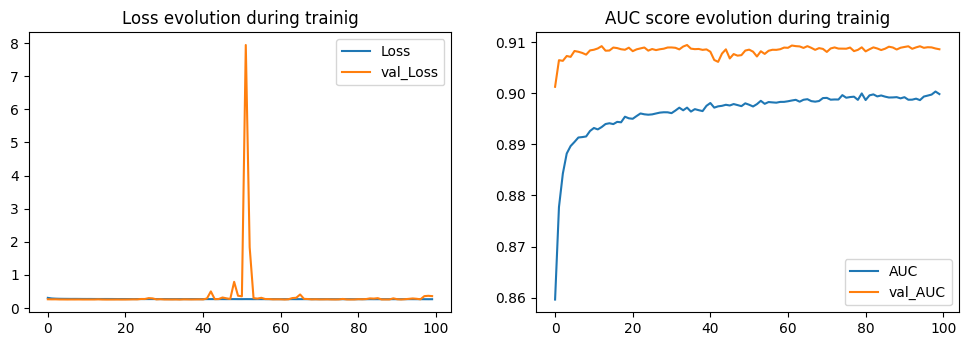

In [34]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss evolution during trainig')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(r.history['AUC'], label='AUC')
plt.plot(r.history['val_AUC'], label='val_AUC')
plt.title('AUC score evolution during trainig')
plt.legend()


In [35]:
y_train_pred = model.predict(X_train)
print("Training Results")
print_score(y_train, y_train_pred.round())

8275/8275 ━━━━━━━━━━━━━━━━━━━━ 5s 614us/step
Training Results
Accuracy Score: 89.16%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.894652       0.891165   0.89155       0.892909       0.891847
recall         0.505106       0.985535   0.89155       0.745320       0.891550
f1-score       0.645675       0.935977   0.89155       0.790826       0.879187
support    51801.000000  212995.000000   0.89155  264796.000000  264796.000000
_______________________________________________
Confusion Matrix: 
 [[ 26165  25636]
 [  3081 209914]]



In [36]:
y_test_pred = model.predict(X_test)
print("Test Results")
print_score(y_test, y_test_pred.round())

4076/4076 ━━━━━━━━━━━━━━━━━━━━ 3s 609us/step
Test Results
Accuracy Score: 88.82%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.884363       0.888630  0.888156       0.886497       0.887789
recall         0.498017       0.984002  0.888156       0.741010       0.888156
f1-score       0.637202       0.933887  0.888156       0.785545       0.875375
support    25722.000000  104701.000000  0.888156  130423.000000  130423.000000
_______________________________________________
Confusion Matrix: 
 [[ 12810  12912]
 [  1675 103026]]



### Model 2: Random Forest Classifier

In [37]:
param_grid = dict(
    max_depth=stats.randint(10, 80),
    min_samples_split=stats.randint(2, 20),
    min_samples_leaf=stats.randint(1, 20),
    max_features=['sqrt', stats.uniform(0.5, 0.5)],
    class_weight=['balanced', 'balanced_subsample', None]
)

rf_clf = RandomForestClassifier(
    n_estimators=1000,
    random_state=42,
    n_jobs=-1
)

rf_halving_cv = HalvingRandomSearchCV(
    estimator=rf_clf,
    param_distributions=param_grid,
    factor=2,  # Eliminate half the candidates at each step
    resource='n_estimators', 
    min_resources=100,       
    max_resources=1000,      
    
    cv=2,
    scoring='roc_auc',
    verbose=2,
    random_state=42,
    n_jobs=-1 
)

print("Starting Halving Random Search...")
rf_halving_cv.fit(X_train, y_train)

print("\nSearch Complete.")
best_params = rf_halving_cv.best_params_
print(f"Best Parameters Found: {best_params}")
print(f"Best ROC AUC Score: {rf_halving_cv.best_score_}")

rf_clf = rf_halving_cv.best_estimator_
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)


Starting Halving Random Search...
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 100
max_resources_: 1000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 10
n_resources: 100
Fitting 2 folds for each of 10 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 5
n_resources: 200
Fitting 2 folds for each of 5 candidates, totalling 10 fits
----------
iter: 2
n_candidates: 3
n_resources: 400
Fitting 2 folds for each of 3 candidates, totalling 6 fits
----------
iter: 3
n_candidates: 2
n_resources: 800
Fitting 2 folds for each of 2 candidates, totalling 4 fits

Search Complete.
Best Parameters Found: {'class_weight': 'balanced_subsample', 'max_depth': 31, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 18, 'n_estimators': 800}
Best ROC AUC Score: 0.8940352658664417


In [38]:
print("Training Result")
print_score(y_train, y_train_pred)

Training Result
Accuracy Score: 90.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.706745       0.958112  0.899987       0.832428       0.908938
recall         0.835389       0.915698  0.899987       0.875543       0.899987
f1-score       0.765701       0.936425  0.899987       0.851063       0.903027
support    51801.000000  212995.000000  0.899987  264796.000000  264796.000000
_______________________________________________
Confusion Matrix: 
 [[ 43274   8527]
 [ 17956 195039]]



In [39]:
print("Test Result")
print_score(y_test, y_test_pred)

Test Result
Accuracy Score: 85.14%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.608176       0.921754  0.851353       0.764965       0.859910
recall         0.692326       0.890421  0.851353       0.791373       0.851353
f1-score       0.647528       0.905817  0.851353       0.776672       0.854877
support    25722.000000  104701.000000  0.851353  130423.000000  130423.000000
_______________________________________________
Confusion Matrix: 
 [[17808  7914]
 [11473 93228]]



### Model 3: XGBoost

In [40]:
param_grid = dict(
    n_estimators=stats.randint(10, 500),
    max_depth=stats.randint(1, 10),
    learning_rate=stats.uniform(0, 1)
)

xgb_clf = XGBClassifier(use_label_encoder=False)
xgb_cv = RandomizedSearchCV(
    xgb_clf, param_grid, cv=3, n_iter=60, 
    scoring='roc_auc', n_jobs=-1, verbose=1
)
xgb_cv.fit(X_train, y_train)

best_params = xgb_cv.best_params_

print(f"Best Parameters: {best_params}")

xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)


y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)


Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best Parameters: {'learning_rate': np.float64(0.09522143097793268), 'max_depth': 4, 'n_estimators': 273}


In [41]:
print("Training Result")
print_score(y_train, y_train_pred)

Training Result
Accuracy Score: 89.21%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.940313       0.886740  0.892075       0.913527       0.897220
recall         0.478697       0.992610  0.892075       0.735654       0.892075
f1-score       0.634422       0.936693  0.892075       0.785557       0.877561
support    51801.000000  212995.000000  0.892075  264796.000000  264796.000000
_______________________________________________
Confusion Matrix: 
 [[ 24797  27004]
 [  1574 211421]]



In [42]:
print("Test Result")
print_score(y_test, y_test_pred)

Test Result
Accuracy Score: 88.91%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.929023       0.884609  0.889076       0.906816       0.893369
recall         0.473758       0.991108  0.889076       0.732433       0.889076
f1-score       0.627514       0.934835  0.889076       0.781174       0.874225
support    25722.000000  104701.000000  0.889076  130423.000000  130423.000000
_______________________________________________
Confusion Matrix: 
 [[ 12186  13536]
 [   931 103770]]



### Comparing the different models

In [43]:
ml_models = {
    'Random Forest': rf_clf, 
    'XGBoost': xgb_clf, 
    'ANN': model
}

print("Comparing Model Performance on Test Set")

for model_name, model_instance in ml_models.items():
    
    if model_name == 'ANN':
        y_scores = model_instance.predict(X_test).flatten()
    else:
        y_scores = model_instance.predict_proba(X_test)[:, 1]

    score = roc_auc_score(y_test, y_scores)
    print(f"{model_name.upper():{30}} roc_auc_score: {score:.4f}")

Comparing Model Performance on Test Set
RANDOM FOREST                  roc_auc_score: 0.8961
XGBOOST                        roc_auc_score: 0.9110
4076/4076 ━━━━━━━━━━━━━━━━━━━━ 3s 650us/step
ANN                            roc_auc_score: 0.9084


### Saving Model Artifacts

In [44]:
joblib.dump(X.columns, 'model_columns.joblib')
print("Saved model columns.")

joblib.dump(imputer, 'imputer.joblib')
print("Saved imputer.")

joblib.dump(scaler, 'scaler.joblib')
print("Saved scaler.")

model.save('ann_model.h5')
print("Saved ANN model.")

joblib.dump(rf_clf, 'random_forest_model.joblib')
print("Saved Random Forest model.")

joblib.dump(xgb_clf, 'xgboost_model.joblib')
print("Saved XGBoost model.")

print("\nArtifact saving complete!")        


Saved model columns.
Saved imputer.
Saved scaler.
Saved ANN model.
Saved Random Forest model.
Saved XGBoost model.

Artifact saving complete!
